<a href="https://colab.research.google.com/github/lianghhhhh/ML_hw3_cnn/blob/main/Copy_of_hw3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集
!unzip food-11.zip # 解壓縮

In [2]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

#Read image
利用 OpenCV (cv2) 讀入照片並存放在 numpy array 中

In [3]:
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [4]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [5]:
# training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [6]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Model

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

#Training

使用 training set 訓練，並使用 validation set 尋找好的參數

In [10]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
    train_loss_record.append(train_loss/train_set.__len__())
    valid_loss_record.append(val_loss/val_set.__len__())
    train_acc_record.append(train_acc/train_set.__len__())
    valid_acc_record.append(val_acc/val_set.__len__())

[001/030] 25.13 sec(s) Train Acc: 0.225826 Loss: 0.018410 | Val Acc: 0.265598 loss: 0.016390
[002/030] 24.86 sec(s) Train Acc: 0.329617 Loss: 0.015020 | Val Acc: 0.248105 loss: 0.020883
[003/030] 24.81 sec(s) Train Acc: 0.383844 Loss: 0.013876 | Val Acc: 0.402624 loss: 0.013535
[004/030] 24.84 sec(s) Train Acc: 0.440199 Loss: 0.012786 | Val Acc: 0.301166 loss: 0.016758
[005/030] 24.74 sec(s) Train Acc: 0.476079 Loss: 0.011883 | Val Acc: 0.398251 loss: 0.013641
[006/030] 24.85 sec(s) Train Acc: 0.507602 Loss: 0.011219 | Val Acc: 0.485131 loss: 0.012030
[007/030] 24.90 sec(s) Train Acc: 0.527063 Loss: 0.010666 | Val Acc: 0.449563 loss: 0.013313
[008/030] 24.90 sec(s) Train Acc: 0.559903 Loss: 0.009949 | Val Acc: 0.475802 loss: 0.013053
[009/030] 24.94 sec(s) Train Acc: 0.579363 Loss: 0.009465 | Val Acc: 0.501749 loss: 0.012510
[010/030] 24.76 sec(s) Train Acc: 0.605210 Loss: 0.008916 | Val Acc: 0.381924 loss: 0.016765
[011/030] 24.65 sec(s) Train Acc: 0.624873 Loss: 0.008497 | Val Acc: 0

 Visusalize data

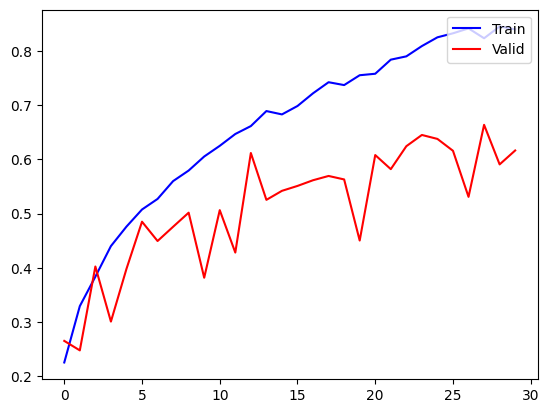

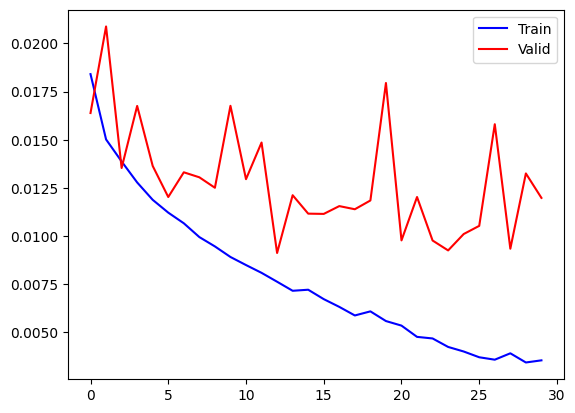

In [11]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()


x = np.arange(len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()

得到好的參數後，我們使用 training set 和 validation set 共同訓練（資料量變多，模型效果較好）

In [12]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [14]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/030] 29.58 sec(s) Train Acc: 0.232250 Loss: 0.017650
[002/030] 29.42 sec(s) Train Acc: 0.358303 Loss: 0.014237
[003/030] 29.50 sec(s) Train Acc: 0.421931 Loss: 0.012851
[004/030] 30.19 sec(s) Train Acc: 0.473601 Loss: 0.011813
[005/030] 30.00 sec(s) Train Acc: 0.505415 Loss: 0.011096
[006/030] 29.43 sec(s) Train Acc: 0.547834 Loss: 0.010114
[007/030] 29.50 sec(s) Train Acc: 0.574684 Loss: 0.009531
[008/030] 29.40 sec(s) Train Acc: 0.608529 Loss: 0.008836
[009/030] 29.59 sec(s) Train Acc: 0.635529 Loss: 0.008309
[010/030] 29.63 sec(s) Train Acc: 0.658243 Loss: 0.007759
[011/030] 29.36 sec(s) Train Acc: 0.674113 Loss: 0.007319
[012/030] 29.47 sec(s) Train Acc: 0.688703 Loss: 0.006970
[013/030] 29.43 sec(s) Train Acc: 0.704347 Loss: 0.006695
[014/030] 29.39 sec(s) Train Acc: 0.730821 Loss: 0.006101
[015/030] 29.57 sec(s) Train Acc: 0.736312 Loss: 0.005930
[016/030] 29.53 sec(s) Train Acc: 0.756318 Loss: 0.005466
[017/030] 29.46 sec(s) Train Acc: 0.760153 Loss: 0.005408
[018/030] 29.4

# Testing
利用剛剛 train 好的 model 進行 prediction

In [15]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [17]:
#將結果寫入 csv 檔
with open("predict.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))